# Imports

In [3]:
!pip install "tensorflow-gpu>=1.15.2,<2.0" ampligraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 411.0 MB 24 kB/s 
     |████████████████████████████████| 168 kB 65.8 MB/s 
     |████████████████████████████████| 3.8 MB 38.1 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
     |████████████████████████████████| 2.9 MB 45.6 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 503 kB 30.6 MB/s 
     |████████████████████████████████| 2.7 MB 50.3 MB/s 
     |████████████████████████████████| 482 kB 69.5 MB/s 
     |████████████████████████████████| 6.4 MB 51.6 MB/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 120 kB 51.1 MB/s 
     |████████████████████████████████| 561 kB 45.1 MB/s 
     |████████████████████████████████| 64 kB 2.2 MB/s 
     |████████████████████████████████| 73 kB 1.4 MB/s 
     |████████████████████████████████|

In [4]:
!pip install adjustText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=0f3d877018be6418a8e03fe20084d6621869a9b92504f48f9d51f92281a2a4e2
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


In [5]:
from ampligraph.evaluation import evaluate_performance
from ampligraph.utils import save_model, restore_model
from rdflib import Graph, URIRef
from ampligraph.evaluation import train_test_split_no_unseen
import numpy as np
import pandas as pd
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import ComplEx
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import tensorflow as tf
from rdflib import URIRef, BNode, Literal, Namespace, Graph
from rdflib.namespace import Namespace, NamespaceManager
from rdflib.plugins import sparql
from rdflib.void import generateVoID
from rdflib.namespace import RDF, RDFS
from rdflib.serializer import Serializer

# Triples

In [8]:
ont_uri = "http://www.semanticweb.org/e1izabeth/ontobooks"
dbpedia_prefix = "http://dbpedia.org/resource/"

In [ ]:
g = Graph()
g.parse("sample_data/MyBooksOWL-out.owl")

In [ ]:
triples = []
books_names = []

for subject, predicate, tobject in g.triples((None, None, None)):
    if predicate.find("type") != -1 & tobject.find("#Books") != -1:
        books_names.append(subject)

for subject, predicate, tobject in g.triples((None, None, None)):
    if subject in books_names:
        if predicate.find(URIRef(ont_uri)) != -1:
            subj = subject.replace(dbpedia_prefix, "book:")
            predicate = predicate.replace(ont_uri + "#", "")
            tobj = tobject.replace(dbpedia_prefix, "")
            triples.append([subj, predicate, tobj])

df = pd.DataFrame(triples, columns=['Subject', 'Predicate', 'Object'])

In [154]:
df

,Subject,Predicate,Object
0,book:Principles_of_Compiler_Design,hasAuthoredBy,Alfred_Aho
1,book:Del-Del,hasAuthoredBy,Victor_Kelleher
2,book:More_Tomorrow_&_Other_Stories,hasTitle,More Tomorrow & Other Stories
3,book:Smiley's_People,hasRating,3.86
4,book:Last_Man_in_Tower,hasTitle,Last Man in Tower
...,...,...,...
19088,book:Out_of_Oz,hasAuthoredBy,Gregory_Maguire
19089,book:Skyward_(novel),hasTitle,Skyward (novel)
19090,book:Fire_Bringer,hasTitle,Fire Bringer
19091,book:Salvage_the_Bones,hasRating,3.0


# Model

In [155]:
X_train, X_test = train_test_split_no_unseen(np.array(triples), test_size=2500)

In [156]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

Train set size:  (17593, 3)
Test set size:  (1500, 3)


In [157]:
mdl = ComplEx(batches_count=50, epochs=300, k=100,
                  eta=20,
                  optimizer='adam',
                  optimizer_params={'lr': 1e-4},
                  loss='multiclass_nll',
                  regularizer='LP',
                  regularizer_params={'p': 3, 'lambda': 1e-5},
                  seed=0,
                  verbose=True)

tf.logging.set_verbosity(tf.logging.ERROR)
mdl.fit(X_train)

save_model(mdl, model_name_path="./my_trained_model")

Average ComplEx Loss:   0.013575: 100%|██████████| 300/300 [17:39<00:00,  3.53s/epoch]


In [158]:
filter_triples = np.concatenate((X_train, X_test))
ranks = evaluate_performance(X_test,
                              model=mdl,
                              filter_triples=filter_triples,
                              use_default_protocol=True,
                              verbose=True)
mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 1500/1500 [01:27<00:00, 17.09it/s]


MRR: 0.03
MR: 4645.29
Hits@10: 0.05
Hits@3: 0.03
Hits@1: 0.02


# Clusterization


In [72]:
mdl = restore_model("sample_data//my_trained_model")

In [74]:
books = df.Subject[df.Subject.str.contains(r'book:.*')].unique()
beast_embeddings = dict(zip(books, mdl.get_embeddings(books)))
beast_embeddings_array = np.array([i for i in beast_embeddings.values()])
embeddings_2d = PCA(n_components=2).fit_transform(beast_embeddings_array)

In [79]:
clustering_algorithm = KMeans(n_clusters=4, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(books, mdl, clustering_algorithm, mode='entity')

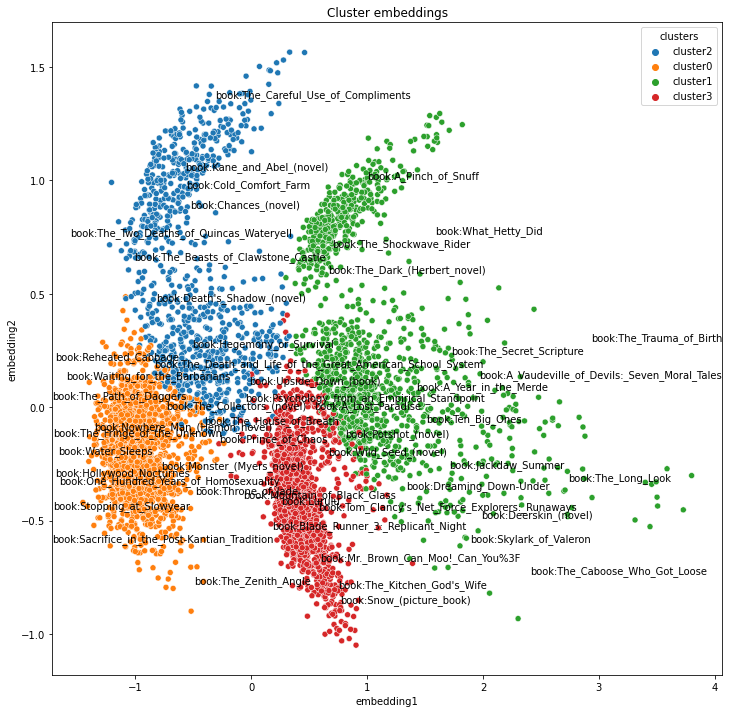

In [80]:
df = pd.DataFrame({"books": books, "clusters": "cluster" + pd.Series(clusters).astype(str),
                       "embedding1": embeddings_2d[:, 0], "embedding2": embeddings_2d[:, 1]})

plt.figure(figsize=(12, 12))
plt.title("Cluster embeddings")

ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue="clusters")

texts = []
for i, point in df.iterrows():
    if np.random.uniform() < 0.01:
        texts.append(plt.text(point['embedding1'] + .02, point['embedding2'], str(point['books'])))
adjust_text(texts)
plt.show()

# Prediction

In [121]:
mdl = restore_model("sample_data//my_trained_model")

In [159]:
X_train

array([['book:A_God_Strolling_in_the_Cool_of_the_Evening',
        'hasAuthoredBy', 'Mário_de_Carvalho'],
       ['book:The_Hostage_of_Zir', 'hasAuthoredBy', 'L._Sprague_de_Camp'],
       ['book:Desolation_Island_(novel)', 'hasTitle',
        'Desolation Island (novel)'],
       ...,
       ['book:I_Am_Not_Spock', 'hasTitle', 'I Am Not Spock'],
       ['book:The_Return_of_the_Black_Widowers', 'hasRating', '4.0'],
       ['book:Dragon_(Cussler_novel)', 'hasTitle',
        'Dragon (Cussler novel)']], dtype='<U113')

In [ ]:
matchSubject = "book:I_Am_Not_Spock"
print(df[df.Subject==matchSubject])

In [116]:
dfFiltered = np.array(df[df.Subject!=matchSubject])
len(dfFiltered)

26055

In [107]:
to_fit = np.array(df)

In [108]:
mdl.fit(to_fit)

Average ComplEx Loss:   0.066642: 100%|██████████| 300/300 [22:55<00:00,  4.59s/epoch]


In [ ]:
statements = np.array([
    [f'{matchSubject}', 'http://www.semanticweb.org/e1izabeth/ontobooks#hasGenre', 'http://dbpedia.org/resource/Nonfiction'],
    [f'{matchSubject}', 'http://www.semanticweb.org/e1izabeth/ontobooks#hasGenre', 'http://dbpedia.org/resource/Novel'],
    [f'{matchSubject}', 'http://www.semanticweb.org/e1izabeth/ontobooks#hasGenre', 'http://dbpedia.org/resource/Science_fiction'],
    [f'{matchSubject}', 'http://www.semanticweb.org/e1izabeth/ontobooks#hasGenre', 'http://dbpedia.org/resource/Historical_fiction'],
    [f'{matchSubject}', 'http://www.semanticweb.org/e1izabeth/ontobooks#hasGenre', 'http://dbpedia.org/resource/Fantasy'],
    [f'{matchSubject}', 'http://www.semanticweb.org/e1izabeth/ontobooks#hasGenre', "http://dbpedia.org/resource/Children's_literature"],
    [f'{matchSubject}', 'http://www.semanticweb.org/e1izabeth/ontobooks#hasGenre', 'http://dbpedia.org/resource/Detective_fiction']
])

In [ ]:
statements_filter = np.array(list({tuple(i) for i in np.vstack((dfFiltered, statements))}))
len(statements_filter)
statements_filter

In [ ]:
ranks_statements = evaluate_performance(
    statements, 
    model=mdl, 
    filter_triples=filter_triples, 
    corrupt_side = 's+o',
    use_default_protocol=False,
    verbose=True,
    filter_unseen=True)

In [ ]:
scores = mdl.predict(statements)
scores

In [ ]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in statements], 
            ranks_statements, 
            np.squeeze(scores),
            np.squeeze(probs))), 
            columns=['statement', 'rank', 'score', 'prob']).sort_values("prob")